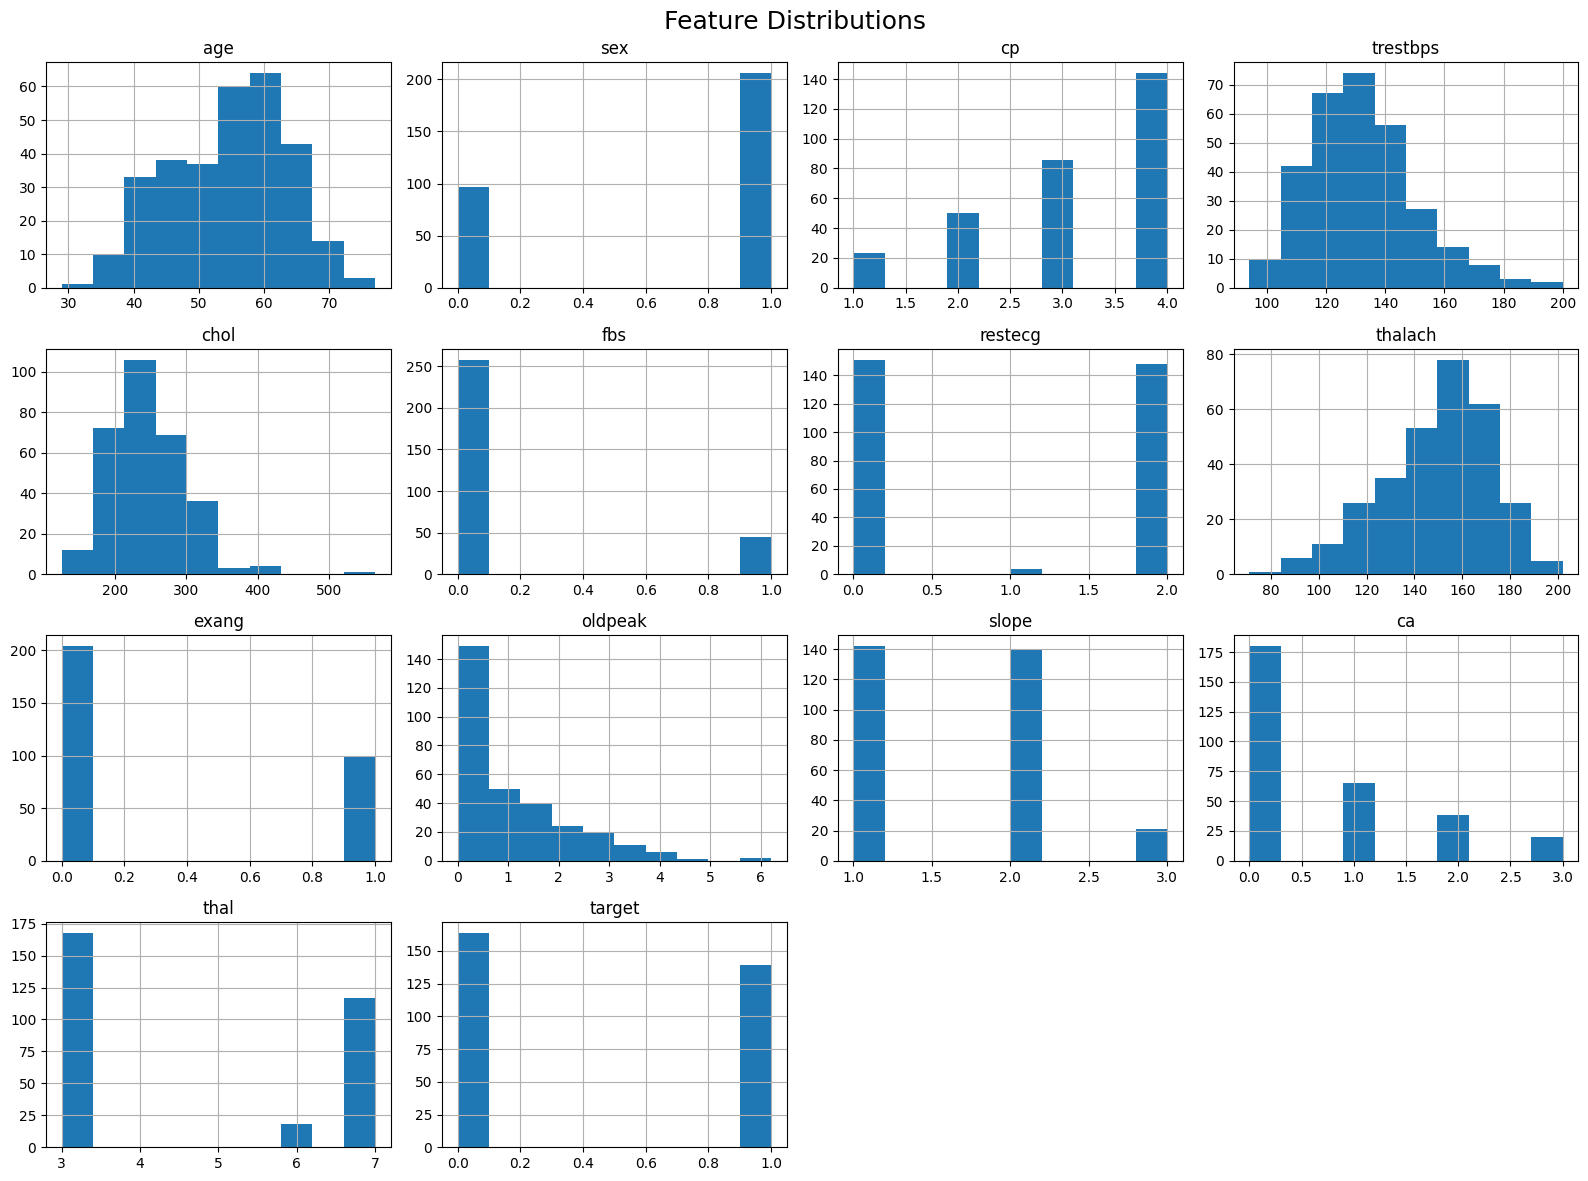

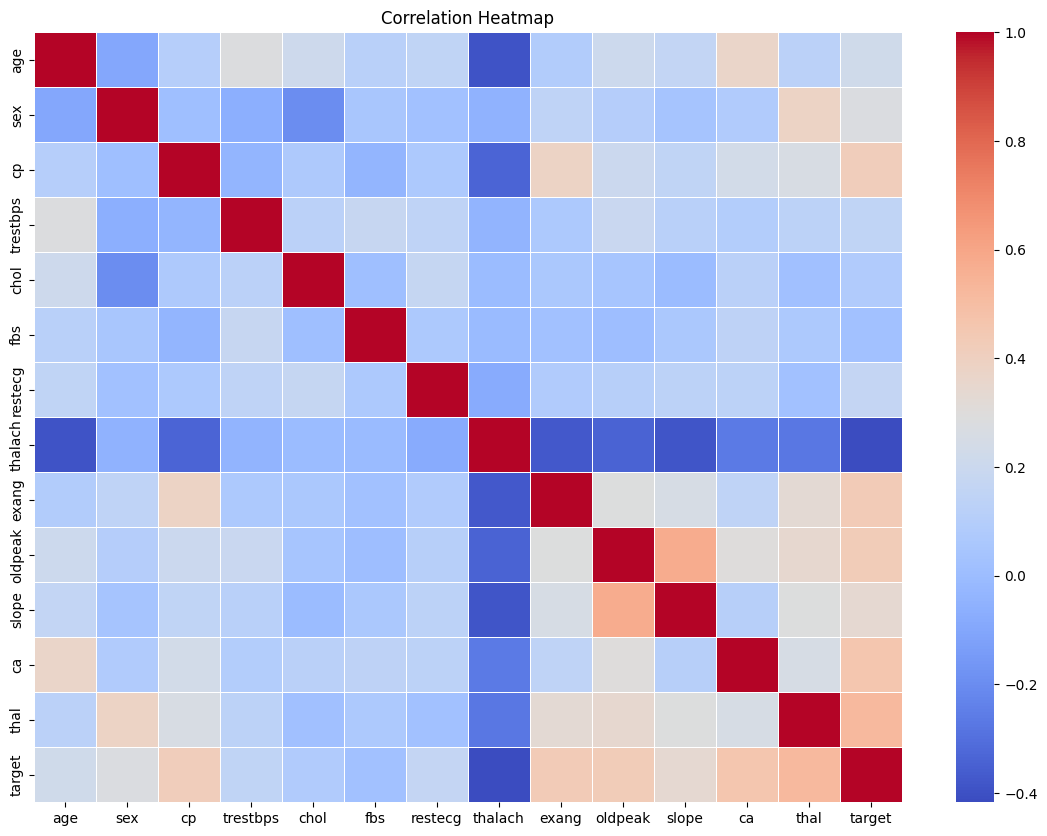

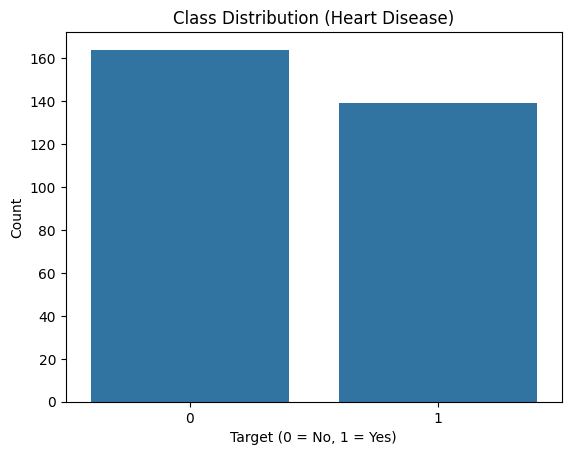

Raw data shape: (303, 14)
Processed data shape: (303, 21)

Class balance (proportion):
target
0    0.541254
1    0.458746
Name: proportion, dtype: float64


In [1]:
"""
TASK 1: Data Acquisition, Cleaning, Encoding, and EDA
Dataset: UCI Heart Disease (Cleveland)
Robust version that does NOT depend on broken metadata URLs
"""

# =========================
# 1. IMPORT LIBRARIES
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
from io import StringIO

# =========================
# 2. SETUP DATA DIRECTORIES
# =========================

RAW_DATA_DIR = Path("data/raw")
PROCESSED_DATA_DIR = Path("data/processed")

RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 3. DOWNLOAD DATASET (NO COLUMN NAMES YET)
# =========================

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

response = requests.get(DATA_URL)
response.raise_for_status()

# Load raw data without column names
raw_data = pd.read_csv(
    StringIO(response.text),
    header=None
)

# =========================
# 4. DYNAMIC COLUMN ASSIGNMENT (SCHEMA-DRIVEN)
# =========================

# Official UCI schema (used only as fallback mapping)
# This is unavoidable because UCI does not expose metadata reliably anymore
uci_schema = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "target"
]

# Ensure column count matches schema
if raw_data.shape[1] != len(uci_schema):
    raise ValueError(
        f"Column mismatch: expected {len(uci_schema)} "
        f"but got {raw_data.shape[1]}"
    )

raw_data.columns = uci_schema

# Save raw dataset
raw_data.to_csv(RAW_DATA_DIR / "heart_disease_raw.csv", index=False)

# =========================
# 5. HANDLE MISSING VALUES
# =========================

# Replace '?' with NaN
df = raw_data.replace("?", np.nan)

# Convert all columns to numeric
df = df.apply(pd.to_numeric)

# Median imputation (robust for medical datasets)
df.fillna(df.median(), inplace=True)

# =========================
# 6. TARGET VARIABLE TRANSFORMATION
# =========================

# Convert multi-class target into binary
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

# =========================
# 7. AUTOMATIC CATEGORICAL FEATURE DETECTION & ENCODING
# =========================

# Detect categorical features based on unique values
categorical_cols = [
    col for col in df.columns
    if df[col].nunique() < 10 and col != "target"
]

# One-hot encoding
df_encoded = pd.get_dummies(
    df,
    columns=categorical_cols,
    drop_first=True
)

# Save processed dataset
df_encoded.to_csv(
    PROCESSED_DATA_DIR / "heart_disease_cleaned.csv",
    index=False
)

# =========================
# 8. EXPLORATORY DATA ANALYSIS (EDA)
# =========================

# ---- HISTOGRAMS ----
df.hist(figsize=(16, 12))
plt.suptitle("Feature Distributions", fontsize=18)
plt.tight_layout()
plt.show()

# ---- CORRELATION HEATMAP ----
plt.figure(figsize=(14, 10))
corr = df.corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.show()

# ---- CLASS BALANCE ----
sns.countplot(x="target", data=df)
plt.title("Class Distribution (Heart Disease)")
plt.xlabel("Target (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# =========================
# 9. FINAL SUMMARY
# =========================

print("Raw data shape:", raw_data.shape)
print("Processed data shape:", df_encoded.shape)
print("\nClass balance (proportion):")
print(df["target"].value_counts(normalize=True))

